# Luther Project: Movies and Stars

1. Read json files with info from BoxOfficeMojo and Oscars websites, and combine into dictionaries, one for training and one for testing.
2. Put dictionaries into Pandas dataframes to process data and make plots.
3. Perform quantile regression on log of Total Domestic Revenue versus Star Value of Cast, and plot results.
4. Compute quantiles separately for each star value, and compare with result of regression.
5. Perform ordinary linear regression on log of Revenue versus log of production budget.

In [1]:
"""
Imports and settings
"""

import json
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import re
import scipy.special as ss
import statsmodels.formula.api as smf
from datetime import datetime
from numpy import power as pwr
from pprint import pprint
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline

save_figures = True

In [2]:
"""
First we want to combine the information from BoxOfficeMojo and from the Oscars
website into a data structure that we can analyze with Pandas.  For each movie
we scraped from BoxOfficeMojo, we want to compute a star value for the cast using
the information we scraped from the Oscars website.
"""

with open("data/aad_oscars.json", "r") as f:
    aad_dict = json.load(f)

for test in [False,True]:
    if test:
        test_movie_data = {}
        years           = [2014]
        ttitle          = "2014 Movies"
    else:
        movie_data      = {}
        years           = [2005,2006,2007,2008,2009,2010,2011,2012,2013]
        gtitle          = "2005 - 2013 Movies"

    for this_year in years:
        with open("data/"+str(this_year)+"_all_movie_dict.json", "r") as f:
            movie_dict = json.load(f)

        for rank,movie in movie_dict.items():
            title      = movie["Title"]

            sum_oscnom = 0.0
            cast_value = 0.0
            nweight    = 1.0 # weight of oscar nominations relative to oscar wins in cast_value
            for actor0 in movie["Actors"]:
                if "(Voice)" in actor0: actor0 = actor0[:-8]
                if "(Narrator)" in actor0: actor0 = actor0[:-11]
                if "(Cameo)" in actor0: actor0 = actor0[:-8]
                actor      = actor0.strip("*")
                if actor in aad_dict:
                    for year in aad_dict[actor][0]:
                        if year <= this_year: cast_value += 1.0
                    for year in aad_dict[actor][1]:
                        if year <= this_year: 
                            cast_value += nweight
                            sum_oscnom += 1.0
            for director in movie["Director"]:
                if director in aad_dict:
                    for year in aad_dict[director][0]:
                        if year <= this_year: cast_value += 1.0
                    for year in aad_dict[director][1]:
                        if year <= this_year: 
                            cast_value += nweight
                            sum_oscnom += 1.0

            dtotal_str = re.compile("[,\$]").sub("", str(movie["Domestic Total"]))
            dtotal = float(dtotal_str) if dtotal_str!="None" else float("nan")

            pbudget_str = re.compile("[,\$]").sub("", str(movie["Production Budget"]))
            if "N/A" in pbudget_str or "None" in pbudget_str:
                pbudget = float("nan")
            elif " million" in pbudget_str:
                pbudget = float(pbudget_str[0:-8])
                pbudget *= 1000000.0
            else:
                pbudget = float(pbudget_str)

            rtime_str = str(movie["Run Time"])
            if "hrs." in rtime_str and "min." in rtime_str:
                loc1   = rtime_str.find("hrs.")
                nhours = int(rtime_str[:loc1])
                loc2   = rtime_str.find("min.")
                nmin   = int(rtime_str[loc1+4:loc2])
                rtime  = float(60*nhours + nmin)
            else:
                rtime  = float("nan")

            rating = movie["MPAA Rating"]

            genre  = movie["Genre"]

            rdate_str = movie["Release Date"]
            if isinstance(rdate_str, str) and "," in rdate_str:
                list1 = rdate_str.split(",")
                year  = int(list1[1])
                list2 = list1[0].split(" ")
                day   = int(list2[1])
                month_str = list2[0].strip(" ")
                month = ["January", "February", "March", "April", "May", "June", 
                         "July", "August", "September", "October", "November", "December"].index(month_str) + 1
                rdate = datetime(year,month,day)
            else:
                rdate = float("nan")

            year_rank = 1000*this_year + int(rank)
            if test:
                test_movie_data[year_rank] = [title,genre,rating,cast_value,sum_oscnom,pbudget,rtime,rdate,dtotal]
            else:
                movie_data[year_rank] = [title,genre,rating,cast_value,sum_oscnom,pbudget,rtime,rdate,dtotal]

print(f"Number of movies in training set: {len(movie_data)}, in test set: {len(test_movie_data)}")

Number of movies in training set: 5408, in test set: 693


In [3]:
"""
Print out some examples of what's in the movie and actor dictionaries.
"""

for year_rank,movie in movie_data.items():
    if movie[3]==9.0 and movie[8]<=10000.0:
        print(f"{year_rank//1000} ({year_rank%1000}): {[str(x) for x in movie]}")
print("")
Actors = ["Colin Firth", "Orlando Bloom", "Patricia Clarkson", "Amber Tamblyn", "Ellen Burstyn"]
for actor in Actors:
    if actor in aad_dict: print(f"{actor}: {aad_dict[actor]}")

2007 (550): ['Slipstream', 'Fantasy Drama', 'R', '9.0', '7.0', 'nan', '110.0', '2007-10-26 00:00:00', '8965.0']
2011 (587): ['Main Street', 'Drama', 'PG', '9.0', '7.0', 'nan', '92.0', '2011-09-09 00:00:00', '2560.0']

Colin Firth: [[2011], [2010]]
Patricia Clarkson: [[], [2004]]
Ellen Burstyn: [[1975], [1972, 1974, 1979, 1981, 2001]]


In [4]:
"""
Make Pandas dataframes with movie data and remove movies with documentary or foreign genre.
"""

Months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
labels = ["Title", "Genre", "MPAA Rating", "Star Value of Cast", "Sum of Oscar Nominations", "Production Budget (US\$)",
          "Length (minutes)", "Release Date", "Domestic Total Revenue (US\$)", "Release Year", "Release Month"]
rejected_genres = ["Documentary", "Foreign", "Foreign / Action", "Foreign / Horror"]

df = pd.DataFrame.from_dict( movie_data, orient="index" )
df["Release Year"] = df[7].dt.year
df["Release Month"] = df[7].dt.month
df.columns  = labels
df2 = df[~df[labels[1]].isin(rejected_genres)]
print(f"Shape of movie training set: {df.shape}, after filter: {df2.shape}")

tdf = pd.DataFrame.from_dict( test_movie_data, orient="index" )
tdf["Release Year"] = tdf[7].dt.year
tdf["Release Month"] = tdf[7].dt.month
tdf.columns = labels
tdf2 = tdf[~tdf[labels[1]].isin(rejected_genres)]
print(f"Shape of movie test set: {tdf.shape}, after filter:  {tdf2.shape}")

cdf = pd.concat([df, tdf])
cdf2 = pd.concat([df2, tdf2])
print(f"Shape of combined movie set: {cdf.shape}, after filter: {cdf2.shape}")

Shape of movie training set: (5408, 11), after filter: (3433, 11)
Shape of movie test set: (693, 11), after filter:  (399, 11)
Shape of combined movie set: (6101, 11), after filter: (3832, 11)


In [5]:
def compute_ci_ratio(df1, feature, target, CL=0.6827):
    """
    - Given a discrete feature from the movie dataset, estimate the fraction of movies
      with unknown target value for each value of that feature, as well as lower and
      upper errors on that fraction, corresponding to a given confidence level CL.
    - Return a dataframe with the information.
    - CL = Confidence level for Clopper-Pearson intervals on ratio of counts.
    """
    CL1 = 1 - CL
    df2 = df1[df1[feature].notna()][[feature, target]].copy()
    df2g = df2.groupby(feature).agg(ktv=(target, "count"), tot=(target, "size"))
    df2g["utv"] = df2g["tot"] - df2g["ktv"]
    print(f'Number of training+test set movies with "{feature}": {len(df2)}, '
          f'and unknown {target}: {df2g["utv"].sum()}')
    df2g["ratio"] = df2g["utv"] / df2g["tot"]
    df2g["ci_lo"] = df2g.apply(lambda x: x["ratio"]-(ss.btdtri(x["utv"],x["tot"]-x["utv"]+1,0.5*CL1) 
                                                   if x["utv"]!=0 else 0.0), axis=1)
    df2g["ci_up"] = df2g.apply(lambda x: (ss.btdtri(x["utv"]+1,x["tot"]-x["utv"],1.0-0.5*CL1) 
                                        if x["utv"]!=x["tot"] else 1.0)-x["ratio"], axis=1)
    return df2g

# Verify that the error bars are longer for CL=0.99 than for CL=0.6827.
df2g1 = compute_ci_ratio(df2, "MPAA Rating", "Production Budget (US\$)", 0.6827)
display(df2g1.head())
df2g2 = compute_ci_ratio(df2, "MPAA Rating", "Production Budget (US\$)", 0.9900)
display(df2g2.head())

assert (df2g2["ci_lo"] >= df2g1["ci_lo"]).all(), "Down errors not increasing with CL"
assert (df2g2["ci_up"] >= df2g1["ci_up"]).all(), "Up errors not increasing with CL"

Number of training+test set movies with "MPAA Rating": 3430, and unknown Production Budget (US\$): 2215


,ktv,tot,utv,ratio,ci_lo,ci_up
MPAA Rating,,,,,,
G,26,74,48,0.648649,0.064042,0.059575
NC-17,0,4,4,1.000000,0.368883,0.000000
PG,195,374,179,0.478610,0.027070,0.027190
PG-13,490,948,458,0.483122,0.016730,0.016767
R,476,1445,969,0.670588,0.012828,0.012585


Number of training+test set movies with "MPAA Rating": 3430, and unknown Production Budget (US\$): 2215


,ktv,tot,utv,ratio,ci_lo,ci_up
MPAA Rating,,,,,,
G,26,74,48,0.648649,0.155681,0.136013
NC-17,0,4,4,1.000000,0.734085,0.000000
PG,195,374,179,0.478610,0.067240,0.067795
PG-13,490,948,458,0.483122,0.042161,0.042332
R,476,1445,969,0.670588,0.032723,0.031584


In [ ]:
"""
Make various plots.
"""

cl = 0.6827 # Confidence level for Clopper-Pearson intervals on ratio of counts.

# Plot distributions of movie release date (by year and by month).
fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(14,4) )
plt.subplots_adjust( wspace=0.25 )

cdf_9 = cdf.loc[cdf["Release Year"] >= 2005].groupby("Release Year").agg(tot=("Title", "count"))
cdf2_9 = cdf2.loc[cdf2["Release Year"] >= 2005].groupby("Release Year").agg(tot=("Title", "count"))
print(f'Number of training+test movies with "{labels[9]}": {cdf_9["tot"].sum()}, after filter: {cdf2_9["tot"].sum()}')
bins = cdf_9.index.astype(int)
axes[0].bar(bins, cdf_9["tot"], color="C0", alpha=0.2, label="all movies")
axes[0].bar(bins, cdf2_9["tot"], color="C0", label="all except foreign and documentaries")
axes[0].set_xticks(bins)
axes[0].set_xticklabels(bins)
axes[0].set_xlabel("Year of Release", fontsize=15)
axes[0].set_ylabel("Number of Movies", fontsize=15)
axes[0].set_ylim(0.0, 900.0)
axes[0].legend(loc="best")
fig.autofmt_xdate() # Rotate x-axis tick labels

cdf_10 = cdf.loc[cdf["Release Year"] >= 2005].groupby("Release Month").agg(tot=("Title", "count"))
cdf2_10 = cdf2.loc[cdf2["Release Year"] >= 2005].groupby("Release Month").agg(tot=("Title", "count"))
print(f'Number of training+test movies with "{labels[10]}": {cdf_10["tot"].sum()}, after filter: {cdf2_10["tot"].sum()}')
bins = cdf_10.index.astype(int)
axes[1].bar(bins, cdf_10["tot"], color="C0", alpha=0.2, label="all movies")
axes[1].bar(bins, cdf2_10["tot"], color="C0", label="all except foreign and documentaries")
axes[1].set_xticks(bins)
axes[1].set_xticklabels(Months)
axes[1].set_xlabel("Month of Release", fontsize=15)
axes[1].set_ylabel("Number of Movies", fontsize=15)
axes[1].set_ylim(0.0, 900.0)
fig.autofmt_xdate()
if save_figures:
    fig.savefig("figures/Movie_Release_Dates.png", dpi=200, bbox_inches="tight")
plt.show()

# Make scatter plot of Total Domestic versus Production budget on a linear scale.
df2_58 = df2.loc[cdf["Release Year"] >= 2005][[labels[5],labels[8]]].dropna()
print(f'Number of training set movies with "{labels[5]}" and "{labels[8]}": {len(df2_58)}')
fig, axes = plt.subplots( nrows=1, ncols=1, figsize=(6,6) )
axes.scatter(df2_58[labels[5]], df2_58[labels[8]], color="C0", alpha=1.0, s=1)
axes.plot([0.0, 0.3E+09], [0.0, 0.3E+09], color="C2", linestyle="--")
axes.plot([0.0, 0.3E+09], [0.0, 0.6E+09], color="C2", linestyle="--")
axes.text(2.0E+08, 2.1E+08, "DTR = PB", ha="left", va="bottom", rotation=23.0, color="C2", fontsize=15)
axes.text(2.0E+08, 4.2E+08, "DTR = 2 x PB", ha="left", va="bottom", rotation=40.0, color="C2", fontsize=15)
axes.set_xlim(0.0, 0.3E+09)
axes.set_xlabel(labels[5], fontsize=15)
axes.set_ylim(0.0, 0.7E+09)
axes.set_ylabel(labels[8], fontsize=15)
axes.set_title(gtitle, fontsize=15)
if save_figures:
    fig.savefig("figures/DT_versus_PB_lin.png", dpi=200, bbox_inches="tight")
plt.show()

# Make scatter plot and projections of Total Domestic versus Production budget on a log-log scale.
fig, axes = plt.subplots( nrows=2, ncols=2, figsize=(12,12) )
plt.subplots_adjust( wspace=0.20, hspace=0.20, top=0.94 )
plt.suptitle(gtitle, fontsize=20)
axes[0,0].hist(df2_58[labels[8]].values, bins=np.logspace(1.0,9.0,50), color="C0", edgecolor="black")
axes[0,0].set_xscale("log")
axes[0,0].set_xlabel(labels[8], fontsize=15)
axes[0,0].set_ylabel("Number of Movies", fontsize=15)
axes[0,1].scatter(df2_58[labels[5]], df2_58[labels[8]], color="C0", alpha=1.0, s=1)
axes[0,1].plot([1.0E+03, 1.0E+09], [1.0E+03,1.0E+09], color="C2", linestyle="--")
axes[0,1].plot([1.0E+03, 1.0E+09], [2.0E+03,2.0E+09], color="C2", linestyle="--")
axes[0,1].text(3.0E+03, 1.0E+04, "DTR = 2 x PB", ha="left", va="bottom", rotation=39.0, color="C2", fontsize=15)
axes[0,1].text(1.0E+04, 4.0E+03, "DTR = PB", ha="left", va="bottom", rotation=39.0, color="C2", fontsize=15)
axes[0,1].set_xlim(1.0E+03, 1.0E+09)
axes[0,1].set_xscale("log")
axes[0,1].set_xlabel(labels[5], fontsize=15)
axes[0,1].set_ylim(1.0E+01, 1.0E+09)
axes[0,1].set_yscale("log")
axes[0,1].set_ylabel(labels[8], fontsize=15)
axes[1,0].axis("off")
axes[1,1].hist(df2_58[labels[5]].values, bins=np.logspace(3.0,9.0,50), color="C0", edgecolor="black")
axes[1,1].set_xscale("log")
axes[1,1].set_xlabel(labels[5], fontsize=15)
axes[1,1].set_ylabel("Number of Movies", fontsize=15)
if save_figures:
    fig.savefig("figures/DT_versus_PB_log.png", dpi=200, bbox_inches="tight")
plt.show()
    
# Histogram of Total Domestic regardless of whether Production Budget is available.
df2_8 = df2.loc[cdf["Release Year"] >= 2005][[labels[8]]].dropna()
print(f'Number of training set movies with "{labels[8]}": {len(df2_8)}')
fig, axes = plt.subplots( nrows=1, ncols=1, figsize=(6,6) )
axes.hist(df2_8[labels[8]].values, bins=np.logspace(1.0,9.0,50), color="C0", edgecolor="black", alpha=1.0)
axes.set_xscale("log")
axes.set_ylim(0.0, 210.0)
axes.set_xlabel(labels[8], fontsize=15)
axes.set_ylabel("Number of Movies", fontsize=15)
axes.set_title(gtitle, fontsize=15)
if save_figures:
    fig.savefig("figures/DT_log.png", dpi=200, bbox_inches="tight")
plt.show()
    
# Make scatter plot and projections of Total Domestic versus Star Value.
df2_38 = df2.loc[cdf["Release Year"] >= 2005][[labels[3],labels[8]]].dropna()
print(f'Number of training set movies with "{labels[3]}" and "{labels[8]}": {len(df2_38)}')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
plt.subplots_adjust(wspace=0.20, hspace=0.20, top=0.94)
plt.suptitle(gtitle, fontsize=20)
axes[0,0].hist(df2_38[labels[8]], bins=np.logspace(1.0,9.0,50), color="C0", edgecolor="black")
axes[0,0].set_ylim(0.0, 210.0)
axes[0,0].set_xscale("log")
axes[0,0].set_xlabel(labels[8], fontsize=15)
axes[0,0].set_ylabel("Number of Movies", fontsize=15)
axes[0,1].scatter(df2_38[labels[3]], df2_38[labels[8]], color="C0", s=1)
axes[0,1].set_yscale("log")
axes[0,1].set_xlim(-1, 30)
axes[0,1].set_ylim(10.0, 1.0E+09)
axes[0,1].set_xlabel(labels[3], fontsize=15)
axes[0,1].set_ylabel(labels[8], fontsize=15)
axes[1,0].axis("off")
axes[1,1].hist(df2_38[labels[3]], bins=range(0,30,1), color="C0", edgecolor="black")
axes[1,1].set_ylim(0.5, 0.5E+04)
axes[1,1].set_yscale("log")
axes[1,1].set_xlabel(labels[3], fontsize=15)
axes[1,1].set_ylabel("Number of Movies", fontsize=15)
if save_figures:
    fig.savefig("figures/DT_versus_SV.png", dpi=200, bbox_inches="tight")
plt.show()

# Plot mean Domestic Total versus month of release, and Domestic Total versus movie length.
df2_78 = df2.loc[df2["Release Year"] >= 2005][[labels[10],labels[8]]].dropna()
print(f'Number of training set movies with "{labels[10]}" and "{labels[8]}": {len(df2_78)}')
df2_68 = df2.loc[df2["Release Year"] >= 2005][[labels[6],labels[8]]].dropna()
print(f'Number of training set movies with "{labels[6]}" and "{labels[8]}": {len(df2_68)}')
fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(12,6) )
plt.subplots_adjust( wspace=0.20, top=0.94 )
plt.suptitle(gtitle, fontsize=20)
df2_78g = df2_78.groupby(labels[10]).mean()
axes[0].bar(df2_78g.index, df2_78g.values.T[0], color="C0", alpha=1.0)
axes[0].set_xticks(df2_78g.index)
axes[0].set_xticklabels(Months, rotation=45, ha="right")
axes[0].set_xlabel("Month of Release", fontsize=15)
axes[0].set_ylabel("Mean Domestic Total (US\$)", fontsize=15)
axes[1].scatter(df2_68[labels[6]], df2_68[labels[8]], color="C0", alpha=1.0, s=1)
axes[1].set_xlabel(labels[6], fontsize=15)
axes[1].set_xlim(0.0, 200.0)
axes[1].set_ylim(1.0E+01, 1.0E+09)
axes[1].set_yscale("log")
axes[1].set_ylabel(labels[8], fontsize=15)
plt.show()

# Plots to study movies with unknown production budgets:
fig = plt.figure(figsize=(13,12))
gs  = gridspec.GridSpec(3,2)
ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,1])
gs.update(left=0.15,top=0.94,wspace=0.50)
plt.suptitle("Fraction of Movies with Unknown Production Budget (2005-2014)", fontsize=20)

# 1. Effect of movie genre
gdf3 = compute_ci_ratio(cdf2[cdf2["Release Year"] >= 2005], labels[1], labels[5], cl)
gdf3 = gdf3.sort_values(by=["ratio", "tot"], ascending=False)
ax1.barh(gdf3.index, gdf3["ratio"], color="C6", alpha=0.7)
ax1.errorbar(gdf3["ratio"], ax1.get_yticks(), xerr=[gdf3["ci_lo"], gdf3["ci_up"]], fmt=" ", color="black", capsize=2)
ax1.margins(y=0.005)
ax1.set_ylabel("Movie Genre",fontsize=15)
ax1.invert_yaxis()
ax1.set_xlim(0.0,1.0)
ax1t = ax1.twinx()
ax1t.set_ylim(ax1.get_ylim())
ax1t.set_yticks(ax1.get_yticks())
ax1t.set_yticklabels(list(gdf3["tot"]))
ax1t.set_ylabel("Number of Movies in Sample",fontsize=15)

# 2. Effect of release month
gdf3 = compute_ci_ratio(cdf2[cdf2["Release Year"] >= 2005], labels[10], labels[5], cl)
ax2.barh(gdf3.index, gdf3["ratio"], color="C6", alpha=0.7)
ax2.set_yticks(gdf3.index)
ax2.errorbar(gdf3["ratio"], ax2.get_yticks(), xerr=[gdf3["ci_lo"], gdf3["ci_up"]], fmt=" ", color="black", capsize=2)
ax2.set_yticklabels(Months)
ax2.set_ylabel("Month of Release",fontsize=15)
ax2.invert_yaxis()
ax2.set_xlim(0.0,1.0)
ax2t = ax2.twinx()
ax2t.set_ylim(ax2.get_ylim())
ax2t.set_yticks(ax2.get_yticks())
ax2t.set_yticklabels(list(gdf3["tot"]))
ax2t.set_ylabel("Number of Movies in Sample",fontsize=15)

# 3. Effect of release year
gdf3 = compute_ci_ratio(cdf2[cdf2["Release Year"] >= 2005], labels[9], labels[5], cl)
gdf3.index = gdf3.index.astype(int)
ax3.barh(gdf3.index, gdf3["ratio"], color="C6", alpha=0.7)
ax3.set_yticks(gdf3.index)
ax3.errorbar(gdf3["ratio"], ax3.get_yticks(), xerr=[gdf3["ci_lo"], gdf3["ci_up"]], fmt=" ", color="black", capsize=2)
ax3.set_ylabel("Year of Release",fontsize=15)
ax3.invert_yaxis()
ax3.set_xlim(0.0,1.0)
ax3t = ax3.twinx()
ax3t.set_ylim(ax3.get_ylim())
ax3t.set_yticks(ax3.get_yticks())
ax3t.set_yticklabels(list(gdf3["tot"]))
ax3t.set_ylabel("Number of Movies in Sample",fontsize=15)

# 4. Effect of MPAA Rating
gdf3 = compute_ci_ratio(cdf2[cdf2["Release Year"] >= 2005], labels[2], labels[5], cl)
ax4.barh(gdf3.index, gdf3["ratio"], color="C6", alpha=0.7)
ax4.errorbar(gdf3["ratio"], ax4.get_yticks(), xerr=[gdf3["ci_lo"], gdf3["ci_up"]], fmt=" ", color="black", capsize=2)
ax4.set_ylabel("MPAA Rating",fontsize=15)
ax4.invert_yaxis()
ax4.set_xlim(0.0,1.0)
ax4t = ax4.twinx()
ax4t.set_ylim(ax4.get_ylim())
ax4t.set_yticks(ax4.get_yticks())
ax4t.set_yticklabels(list(gdf3["tot"]))
ax4t.set_ylabel("Number of Movies in Sample",fontsize=15)
if save_figures:
    fig.savefig("figures/G_RD_R.png", dpi=200, bbox_inches="tight")
plt.show()


Fit 1: constant + linear terms, using all data points:

                         QuantReg Regression Results                          
Dep. Variable:                  LogDT   Pseudo R-squared:              0.06938
Model:                       QuantReg   Bandwidth:                      0.4122
Method:                 Least Squares   Sparsity:                        5.709
Date:                Sun, 31 Dec 2023   No. Observations:                 3313
Time:                        15:18:33   Df Residuals:                     3311
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8087      0.036    104.389      0.000       3.737       3.880
SVC            0.1757      0.012     14.621      0.000       0.152       0.199

Fit 2: constant + linear terms, using all data points with SVC<=14:

    

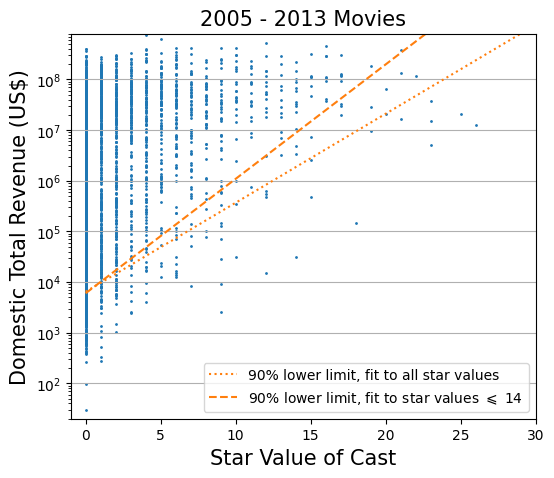

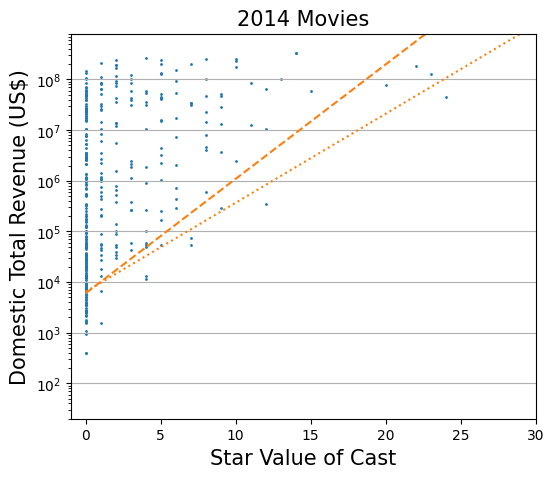

In [7]:
"""
Perform quantile regression on "Domestic Total" versus "Star Value of Cast" 
to determine a lower limit on the former as a function of the latter.  We
want to be able to make a prediction of the form "If the star value of the
cast equals x, then there is a probability of 90% that the domestic total 
will exceed y", where y is an increasing function of x.
"""

def map_rows(inrow):
    outrow = inrow[:] # This preserves the input data structure (list or series...) in the output
    outrow.iloc[1] = np.log10(outrow.iloc[1])
    return outrow


# Define two fit models and perform corresponding fits.
qval        = 0.10
df3         = df2[[labels[3], labels[8]]].dropna()
df3.columns = ["SVC", "LogDT"]
df3.apply(map_rows, axis=1)
model1      = smf.quantreg("LogDT ~ SVC", df3[df3.SVC<=30])
result1     = model1.fit(q=qval)
model2      = smf.quantreg("LogDT ~ SVC", df3[df3.SVC<=14])
result2     = model2.fit(q=qval)
c1          = [result1.params["Intercept"], result1.params["SVC"]]
c2          = [result2.params["Intercept"], result2.params["SVC"]]

# Print out fit results.
print("\nFit 1: constant + linear terms, using all data points:\n")
print(result1.summary())
print("\nFit 2: constant + linear terms, using all data points with SVC<=14:\n")
print(result2.summary())

print("\n                  |         Fit to all data points         | Fit to all data points with SVC<=14")
print("SVC Ntotal Ctotal | Limit       Nbelow           Cbelow    |  Limit       Nbelow           Cbelow")
print("------------------|----------------------------------------|----------------------------------------")
ctotal  = 0.0
cbelow1 = 0.0
cbelow2 = 0.0
for i in range(31):
    LogDTLim1 = c1[0]+c1[1]*i
    LogDTLim2 = c2[0]+c2[1]*i
    ntotal = len(df3[df3.SVC==i])
    ctotal += ntotal
    if ntotal != 0:
        nbelow1 = len(df3[(df3.SVC==i) & (df3.LogDT<=LogDTLim1)])
        cbelow1 += nbelow1
        nbfrac1 = (100.0*nbelow1)/ntotal
        cbfrac1 = (100.0*cbelow1)/ctotal
        nbelow2 = len(df3[(df3.SVC==i) & (df3.LogDT<=LogDTLim2)])
        cbelow2 += nbelow2
        nbfrac2 = (100.0*nbelow2)/ntotal
        cbfrac2 = (100.0*cbelow2)/ctotal
        print("%2d   %4d   %4d  |%6.3f  %4d (%6.2f%%)   %4d (%6.2f%%) | %6.3f  %4d (%6.2f%%)   %4d (%6.2f%%)"\
              %(i,ntotal,ctotal,LogDTLim1,nbelow1,nbfrac1,cbelow1,cbfrac1,
                                LogDTLim2,nbelow2,nbfrac2,cbelow2,cbfrac2))
print("----------------------------------------------------------------------------------------------------")

# Apply fit results to test data set.
tdf3         = tdf2[[labels[3],labels[8]]].dropna()
tdf3.columns = ["SVC","LogDT"]
tdf3.apply(map_rows,axis=1)
nttotal      = len(tdf3)
ntbelow1     = len(tdf3[tdf3.LogDT<=c1[0]+c1[1]*tdf3.SVC])
ntbfrac1     = (100.0*ntbelow1)/nttotal
ntbelow2     = len(tdf3[tdf3.LogDT<=c2[0]+c2[1]*tdf3.SVC])
ntbfrac2     = (100.0*ntbelow2)/nttotal
print(f"\nTest data set: Total={nttotal}, Below(fit1)={ntbelow1} ({ntbfrac1:4.1f}%), "
      f"Below(fit2)={ntbelow2} ({ntbfrac2:4.1f}%)\n")

# Make plots.
q1label    = f"{100.0*(1.0-qval):2.0f}% lower limit, fit to all star values"
q2label    = fr"{100.0*(1.0-qval):2.0f}% lower limit, fit to star values $\leqslant$ 14"
x      = np.arange(0.0, 30.0, 1.0)
get_y  = lambda c: 10**(c[0] + c[1]*x)
y1     = get_y(c1)
y2     = get_y(c2)

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
axis.set_title(gtitle, fontsize=15)
axis.scatter(df2[labels[3]], df2[labels[8]], color="C0", alpha=1.0, s=1)
axis.plot(x, y1, linestyle="dotted", color="C1", label=q1label)
axis.plot(x, y2, linestyle="dashed", color="C1", label=q2label)
axis.set_xlim(-1, 30)
axis.set_xlabel(labels[3], fontsize=15)
axis.set_ylim(20.0, 0.8E+09)
axis.set_yscale("log")
axis.set_ylabel(labels[8], fontsize=15)
axis.grid(which="major", axis="y")
axis.legend(loc="best", fontsize=10)
if save_figures:
    fig.savefig("figures/DT_versus_SV_2fits.png", dpi=200, bbox_inches="tight")
plt.show()

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
axis.set_title(ttitle, fontsize=15)
axis.scatter(tdf2[labels[3]], tdf2[labels[8]], color="C0", s=1, alpha=1.0)
axis.plot(x, y1, linestyle="dotted", color="C1", label=q1label)
axis.plot(x, y2, linestyle="dashed", color="C1", label=q2label)
axis.set_xlim(-1, 30)
axis.set_xlabel(labels[3], fontsize=15)
axis.set_ylim(20.0, 0.8E+09)
axis.set_yscale("log")
axis.set_ylabel(labels[8], fontsize=15)
axis.grid(which="major", axis="y")
plt.show()

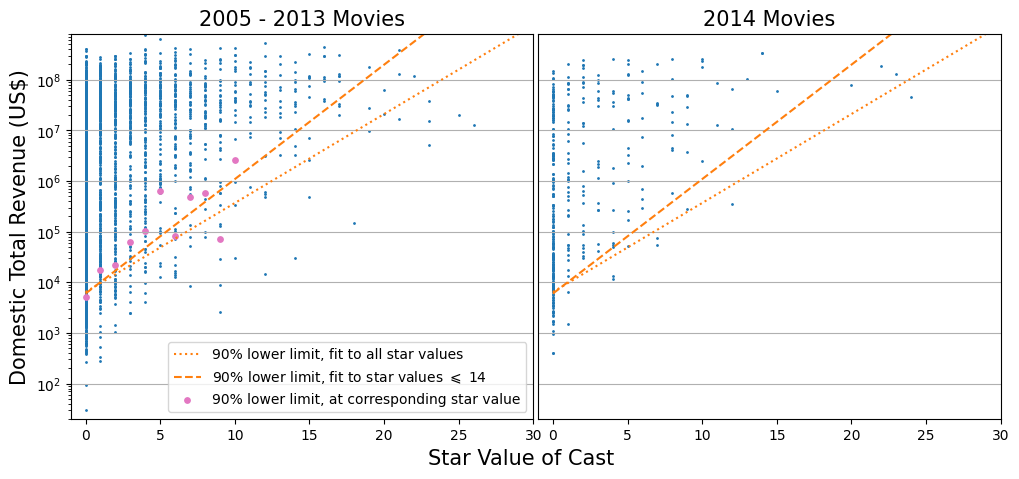

In [8]:
"""
Here we compute data percentiles as a function of star value of cast 
and compare with result of quantile regression.
"""

# First compute percentile in each SVC bucket separately, for SVC<=9
lolim_list = []
svc_list   = []
for star_value in range(10):
    dt_list = []
    for movie in movie_data.values():
        if movie[3]==star_value and movie[1] not in rejected_genres:
            if movie[8]==movie[8]:            # Eliminate NaN in movie[8] (domestic total)
                dt_list.append(movie[8])

    dt_list.sort()
    rindex = qval*len(dt_list)
    rfloor = math.floor(rindex)
    rceil  = math.ceil(rindex)
    iindex = int(rfloor if rindex-rfloor<rceil-rindex else rceil)-1
    lolim  = dt_list[iindex]
    lolim_list.append(lolim)
    svc_list.append(star_value)
    
# Next, compute percentile in all SVC>9 buckets combined.
dt_list = []
for movie in movie_data.values():
    if movie[3]>9 and movie[1] not in rejected_genres:
        if movie[8]==movie[8]:
            dt_list.append(movie[8])

dt_list.sort()
rindex = qval*len(dt_list)
rfloor = math.floor(rindex)
rceil  = math.ceil(rindex)
iindex = int(rfloor if rindex-rfloor<rceil-rindex else rceil)-1
lolim  = dt_list[iindex]
lolim_list.append(lolim)
svc_list.append(10)

# Make a plot
q1label   = f"{100.0*(1.0-qval):2.0f}% lower limit, fit to all star values"
q2label   = fr"{100.0*(1.0-qval):2.0f}% lower limit, fit to star values $\leqslant$ 14"
q3label   = f"{100.0*(1.0-qval):2.0f}% lower limit, at corresponding star value"
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True)
plt.subplots_adjust(wspace=0.01)
axis[0].set_title(gtitle, fontsize=15)
axis[0].scatter(df2[labels[3]], df2[labels[8]], color="C0", alpha=1.0, s=1)
axis[0].plot(x, y1, linestyle="dotted", color="C1", label=q1label)
axis[0].plot(x, y2, linestyle="dashed", color="C1", label=q2label)
axis[0].scatter(svc_list, lolim_list, color="C6", s=15, label=q3label)
axis[0].set_xlim(-1, 30)
axis[0].set_ylim(20.0, 0.8E+09)
axis[0].set_yscale("log")
axis[0].set_ylabel(labels[8],fontsize=15)
axis[0].grid(which="major", axis="y")
axis[0].legend(loc="best", fontsize=10)

# Add plot from previous cell for the portfolio.
axis[1].set_title(ttitle, fontsize=15)
axis[1].scatter(tdf2[labels[3]], tdf2[labels[8]], color="C0", alpha=1.0, s=1)
axis[1].plot(x, y1, linestyle="dotted", color="C1", label=q1label)
axis[1].plot(x, y2, linestyle="dashed", color="C1", label=q2label)
axis[1].set_xlim(-1, 30)
axis[1].set_ylim(20.0, 0.8E+09)
axis[1].set_yscale("log")
axis[1].yaxis.set_tick_params(which="both", length=0, labelleft=False)
axis[1].grid(which="major", axis="y")
fig.supxlabel(labels[3], fontsize=15)
if save_figures:
    fig.savefig("figures/DT_versus_SV_2fits_sq_2014.png", dpi=200, bbox_inches="tight")
plt.show()


Fit 1: constant & linear terms, using all data points with SVC<=9:

                         QuantReg Regression Results                          
Dep. Variable:                  LogDT   Pseudo R-squared:              0.05966
Model:                       QuantReg   Bandwidth:                      0.4156
Method:                 Least Squares   Sparsity:                        5.708
Date:                Sun, 31 Dec 2023   No. Observations:                 3187
Time:                        15:18:40   Df Residuals:                     3185
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7625      0.037    102.991      0.000       3.691       3.834
SVC            0.2530      0.016     15.999      0.000       0.222       0.284

Fit 2: constant & linear terms, using all data points with SV

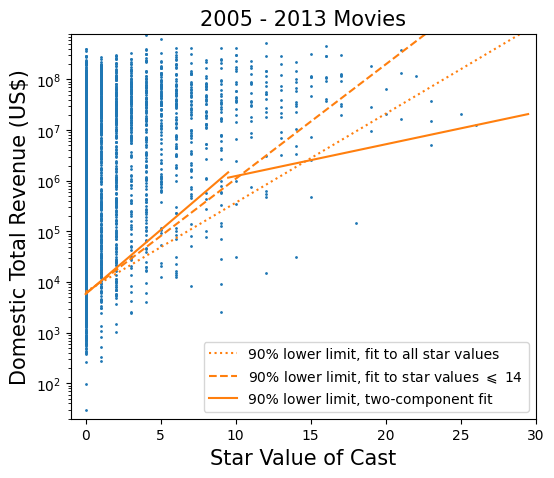

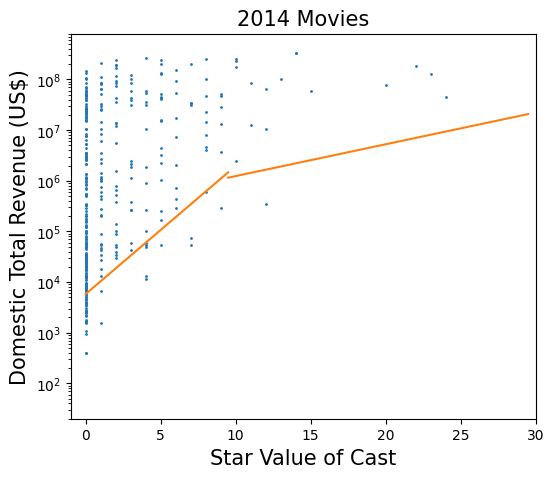

In [9]:
"""
Perform quantile regression on "Domestic Total" versus "Star Value of Cast" 
using a more sophisticated model with two components, one for low star values
and one for high star values.
"""


def map_rows(inrow):
    outrow = inrow[:] # This preserves the input data structure (list or series...) in the output
    outrow.iloc[1] = np.log10(outrow.iloc[1])
    return outrow


# Define two fit models and perform corresponding fits.
qval        = 0.10
df3         = df2[[labels[3],labels[8]]].dropna()
df3.columns = ["SVC","LogDT"]
df3.apply(map_rows,axis=1)
model1      = smf.quantreg("LogDT ~ SVC", df3[df3.SVC<=9])
result1     = model1.fit(q=qval)
model2      = smf.quantreg("LogDT ~ SVC", df3[df3.SVC>9])
result2     = model2.fit(q=qval)
c1          = [result1.params["Intercept"], result1.params["SVC"]]
c2          = [result2.params["Intercept"], result2.params["SVC"]]

# Print out fit results.
print("\nFit 1: constant & linear terms, using all data points with SVC<=9:\n")
print(result1.summary())
print("\nFit 2: constant & linear terms, using all data points with SVC>9:\n")
print(result2.summary())

print("SVC Ntotal Ctotal | Limit       Nbelow           Cbelow    ")
print("------------------|----------------------------------------")
ctotal  = 0.0
cbelow  = 0.0
for i in range(31):
    if i <= 9:
        LogDTLim = c1[0]+c1[1]*i
    else:
        LogDTLim = c2[0]+c2[1]*i
    ntotal = len(df3[df3.SVC==i])
    ctotal += ntotal
    if ntotal != 0:
        nbelow = len(df3[(df3.SVC==i) & (df3.LogDT<=LogDTLim)])
        cbelow += nbelow
        nbfrac = (100.0*nbelow)/ntotal
        cbfrac = (100.0*cbelow)/ctotal
        print("%2d   %4d   %4d  |%6.3f  %4d (%6.2f%%)   %4d (%6.2f%%)"\
              %(i,ntotal,ctotal,LogDTLim,nbelow,nbfrac,cbelow,cbfrac))
print("-----------------------------------------------------------")

# Apply fit results to test data set.
tdf3         = tdf2[[labels[3],labels[8]]].dropna()
tdf3.columns = ["SVC","LogDT"]
tdf3.apply(map_rows,axis=1)
nttotal      = len(tdf3)
ntbelow      = len(tdf3[(tdf3.SVC<=9)&(tdf3.LogDT<=c1[0]+c1[1]*tdf3.SVC)])
ntbelow     += len(tdf3[(tdf3.SVC>9)&(tdf3.LogDT<=c2[0]+c2[1]*tdf3.SVC)])
ntbfrac      = (100.0*ntbelow)/nttotal
print("\nTest data set: Total=%i, Below=%i (%f%%)" %(nttotal,ntbelow,ntbfrac))

# Make plots.
q3label = "{0:2.0f}% lower limit, two-component fit".format(100.0*(1.0-qval))
x3 = np.arange(0.0, 10.0, 0.5)
x4 = np.arange(9.5, 30.0, 0.5)
y3 = 10**(c1[0] + c1[1]*x3)
y4 = 10**(c2[0] + c2[1]*x4)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
axis.set_title(gtitle, fontsize=15)
axis.scatter(df2[labels[3]], df2[labels[8]], color="C0", alpha=1.0, s=1)
axis.plot(x, y1, linestyle="dotted", color="C1", label=q1label)
axis.plot(x, y2, linestyle="dashed", color="C1", label=q2label)
axis.plot(x3, y3, linestyle="solid", color="C1", label=q3label)
axis.plot(x4, y4, linestyle="solid", color="C1")
axis.set_xlim(-1, 30)
axis.set_ylim(20.0, 0.8E+09)
axis.set_yscale("log")
axis.set_xlabel(labels[3], fontsize=15)
axis.set_ylabel(labels[8], fontsize=15)
axis.legend(loc="lower right")
if save_figures:
    fig.savefig("figures/DT_versus_SV_2cfit.png", dpi=200, bbox_inches="tight")
plt.show()

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
axis.set_title(ttitle, fontsize=15)
axis.scatter(tdf2[labels[3]], tdf2[labels[8]], color="C0", alpha=1.0, s=1)
axis.plot(x3, y3, linestyle="solid", color="C1")
axis.plot(x4, y4, linestyle="solid", color="C1")
axis.set_xlim(-1, 30)
axis.set_ylim(20.0, 0.8E+09)
axis.set_yscale("log")
axis.set_xlabel(labels[3], fontsize=15)
axis.set_ylabel(labels[8], fontsize=15)
plt.show()


Fit of LogDT to InvSVC:

                         QuantReg Regression Results                          
Dep. Variable:                  LogDT   Pseudo R-squared:              0.08634
Model:                       QuantReg   Bandwidth:                      0.4122
Method:                 Least Squares   Sparsity:                        5.779
Date:                Sun, 31 Dec 2023   No. Observations:                 3313
Time:                        15:18:43   Df Residuals:                     3308
                                        Df Model:                            4
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.5224      0.455     16.519      0.000       6.630       8.415
InvSVC                -21.6427      7.223     -2.996      0.003     -35.806      -7.480
np.power(InvSVC, 2)    54.1686     35.274      1.536      0.125     -

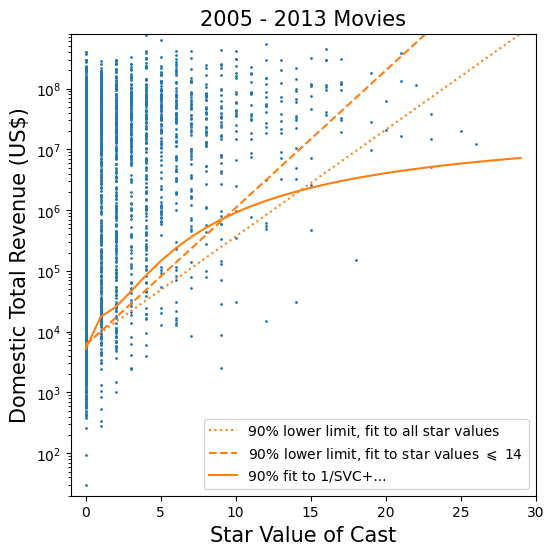

In [10]:
"""
Here we fit to a (linear) saturated growth model.
"""


def map_rows(inrow):
    outrow = inrow[:] # This preserves the input data structure (list or series...) in the output
    outrow.iloc[0] = 1.0/(outrow.iloc[0]+1)
    outrow.iloc[1] = np.log10(outrow.iloc[1])
    return outrow

# Define fit model and perform fit.
qval        = 0.10
df3         = df2[[labels[3],labels[8]]].dropna()
df3.columns = ["InvSVC","LogDT"]
df3.apply(map_rows,axis=1)
model5      = smf.quantreg("LogDT ~ InvSVC + np.power(InvSVC,2)+ np.power(InvSVC,3)+ np.power(InvSVC,4)", df3)
result5     = model5.fit(q=qval)
c5          = [result5.params["Intercept"], 
               result5.params["InvSVC"], 
               result5.params["np.power(InvSVC, 2)"], 
               result5.params["np.power(InvSVC, 3)"],
               result5.params["np.power(InvSVC, 4)"],
              ]

# Print out fit results.
print("\nFit of LogDT to InvSVC:\n")
print(result5.summary())

print("SVC Ntotal Ctotal | Limit       Nbelow           Cbelow    ")
print("------------------|----------------------------------------")
ctotal  = 0.0
cbelow  = 0.0
for i in range(31):
    LogDTLim = c5[0]+c5[1]/(i+1)+c5[2]/(i+1)**2+c5[3]/(i+1)**3+c5[4]/(i+1)**4
    ntotal   = len(df3[df3.InvSVC==1.0/(i+1)])
    ctotal  += ntotal
    if ntotal != 0:
        nbelow  = len(df3[(df3.InvSVC==1.0/(i+1)) & (df3.LogDT<=LogDTLim)])
        cbelow += nbelow
        nbfrac  = (100.0*nbelow)/ntotal
        cbfrac  = (100.0*cbelow)/ctotal
        print("%2d   %4d   %4d  |%6.3f  %4d (%6.2f%%)   %4d (%6.2f%%)"\
              %(i,ntotal,ctotal,LogDTLim,nbelow,nbfrac,cbelow,cbfrac))
print("-----------------------------------------------------------")

# Make plots.
q5label = f"{100.0*(1.0-qval):2.0f}% fit to 1/SVC+..."
x5 = np.arange(0.0, 30.0, 1.0)
y5 = 10**(c5[0] + c5[1]/(x5+1.) + c5[2]/(x5+1.)**2 + c5[3]/(x5+1.)**3 + c5[4]/(x5+1.)**4)
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,6) )
axis.set_title(gtitle, fontsize=15)
axis.scatter(df2[labels[3]], df2[labels[8]], color="C0", alpha=1.0, s=1)
axis.plot(x, y1, linestyle="dotted", color="C1", label=q1label)
axis.plot(x, y2, linestyle="dashed", color="C1", label=q2label)
axis.plot(x5, y5, linestyle="solid", color="C1", label=q5label)
axis.set_xlim(-1, 30)
axis.set_ylim(20.0, 0.8E+09)
axis.set_yscale("log")
axis.set_xlabel(labels[3],fontsize=15)
axis.set_ylabel(labels[8],fontsize=15)
axis.legend(loc="lower right")
if save_figures:
    fig.savefig("figures/DT_versus_SV_InvSVCFit.png", dpi=200, bbox_inches="tight")
plt.show()

                                 OLS Regression Results                                
Dep. Variable:                  LogDT   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          1.389e+05
Date:                Sun, 31 Dec 2023   Prob (F-statistic):                        0.00
Time:                        15:18:45   Log-Likelihood:                         -1253.6
No. Observations:                1206   AIC:                                      2509.
Df Residuals:                    1205   BIC:                                      2514.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

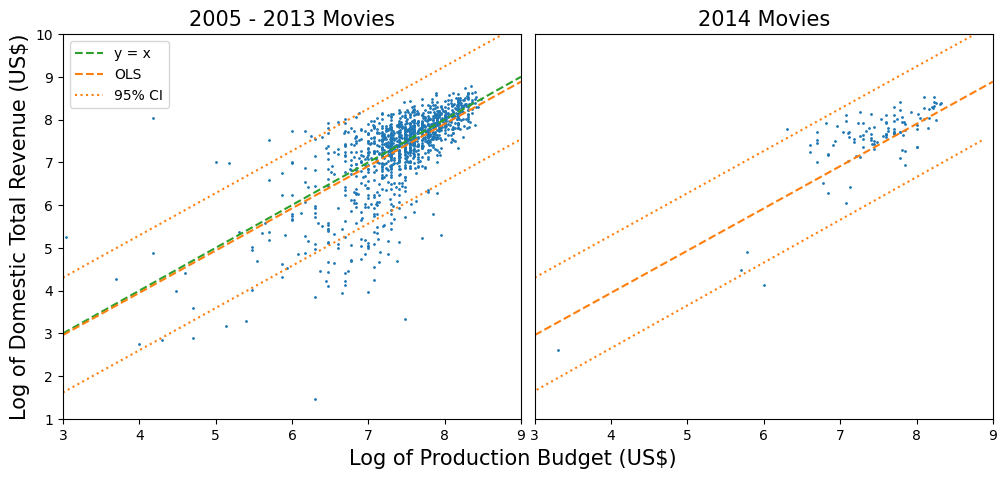

In [11]:
"""
Do an ordinary least-squares regression of total domestic revenue versus production budget.
"""


def map_rows2(inrow):
    outrow = inrow[:]
    outrow.iloc[0] = np.log10(outrow.iloc[0])
    outrow.iloc[1] = np.log10(outrow.iloc[1])
    return outrow

# Define two fit models and perform corresponding fits.
df4          = df2[[labels[5],labels[8]]].dropna()
df4.columns  = ["LogPB","LogDT"]
df4.apply(map_rows2,axis=1)

tdf4         = tdf2[[labels[5],labels[8]]].dropna()
tdf4.columns = ["LogPB","LogDT"]
tdf4.apply(map_rows2,axis=1)

model        = smf.ols("LogDT ~ LogPB-1", df4).fit()  # Constrain the fit to go through (0,0)
print(model.summary())
fitc1        = model.params["LogPB"]

predictions  = model.predict(tdf4)

# Make plots.
xarray          = [3.0,9.0]
yarray          = [x*fitc1 for x in xarray]
xxarray         = [[x] for x in xarray]
prstd,iv_l,iv_u = wls_prediction_std(model,exog=xxarray,alpha=0.05)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True)
plt.subplots_adjust(wspace=0.03)
ax[0].set_title(gtitle, fontsize=15)
ax[0].scatter(df4["LogPB"], df4["LogDT"], color="C0", alpha=1.0, s=1)
ax[0].plot([3.0,9.0], [3.0,9.0], color="C2", linestyle="--", label="y = x")
ax[0].plot(xarray, yarray, color="C1", linestyle="--", label="OLS")
ax[0].plot(xarray, iv_u, color="C1", linestyle=":", label="95% CI")
ax[0].plot(xarray, iv_l, color="C1", linestyle=":")
ax[0].set_xlim(3.0,9.0)
ax[0].set_ylim(1.0,10.0)
ax[0].set_ylabel("Log of Domestic Total Revenue (US\$)", fontsize=15)
ax[0].legend(loc="best", fontsize=10)

ax[1].set_title(ttitle, fontsize=15)
ax[1].scatter(tdf4["LogPB"], tdf4["LogDT"], color="C0", alpha=1.0, s=1, label="2014 data")
ax[1].plot(xarray, yarray, color="C1", linestyle="--", label="OLS(2005 - 2013)")
ax[1].plot(xarray, iv_u, color="C1", linestyle=":", label="95% CI")
ax[1].plot(yarray, iv_l, color="C1", linestyle=":")
ax[1].set_xlim(3.0,9.0)
ax[1].set_ylim(1.0,10.0)
ax[1].yaxis.set_tick_params(which="both", length=0, labelleft=False)
fig.supxlabel("Log of Production Budget (US\$)", fontsize=15)
if save_figures:
    fig.savefig("figures/DT_vs_PB_fit_test.pdf", dpi=200, bbox_inches="tight")
plt.show()